In [1]:
import time
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from pyspark.sql import SparkSession
from pyspark.sql.functions import min, max, mean, stddev, count, log, when, col, sum, desc
from pyspark.sql.functions import year, month, dayofmonth, hour, minute, second


from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.regression import RandomForestRegressor, GBTRegressor, LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

In [2]:
spark = SparkSession.builder.master("local[*]").appName("accidents") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.cores", "4") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

data = spark.read.csv(f"../US_Accidents_March23.csv", header=True, inferSchema=True)
data.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [3]:
data.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [4]:
print("Nombre de lignes :", data.count())

Nombre de lignes : 7728394


In [5]:
print("Nombre de lignes avec des valeurs manquantes :")
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

Nombre de lignes avec des valeurs manquantes :
+---+------+--------+----------+--------+---------+---------+-------+-------+------------+-----------+------+----+------+-----+-------+-------+--------+------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID|Source|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|End_Lat|End_Lng|Distance(mi)|Description|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_L

We will drop feature with more than 100 000 missing values.

In [6]:
missing_counts = data.select([
    sum(when(col(c).isNull(), 1).otherwise(0)).alias(c) for c in data.columns
])

missing_dict = missing_counts.collect()[0].asDict()
columns_with_missing_gt_100k = [col_name for col_name, count in missing_dict.items() if count > 100000]

print("Colonnes avec plus de 100 000 valeurs manquantes :")
print(columns_with_missing_gt_100k)


Colonnes avec plus de 100 000 valeurs manquantes :
['End_Lat', 'End_Lng', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition']


In [7]:
data =  data.drop(*columns_with_missing_gt_100k)
data.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+---+-------+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+-------------------

We'll drop the Description, ID and Source features.

In [8]:
data = data.drop("Description", "ID", "Source")
data.show(5)

+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|Distance(mi)|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------+-----+--------+-

In [9]:
print("Nombre de lignes avec des valeurs manquantes :")
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

Nombre de lignes avec des valeurs manquantes :
+--------+----------+--------+---------+---------+------------+------+----+------+-----+-------+-------+--------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+--------+----------+--------+---------+---------+------------+------+----+------+-----+-------+-------+--------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+-------------

Impute most frequent value for categarial features.

In [10]:
features_cat = ["Street", "City", "Zipcode", "Timezone", "Airport_Code", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]

for feature in features_cat:
    mode_value = data.groupBy(feature).count().orderBy(desc("count")).first()[0]
    data = data.fillna({feature: mode_value})

print("Nombre de lignes avec des valeurs manquantes :")
data.select([sum(col(c).isNull().cast("int")).alias(c) for c in data.columns]).show()

Nombre de lignes avec des valeurs manquantes :
+--------+----------+--------+---------+---------+------------+------+----+------+-----+-------+-------+--------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|Street|City|County|State|Zipcode|Country|Timezone|Airport_Code|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+--------+----------+--------+---------+---------+------------+------+----+------+-----+-------+-------+--------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+-------------

In [11]:
data.printSchema()

root
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Street: string (nullable = false)
 |-- City: string (nullable = false)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = false)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = false)
 |-- Airport_Code: string (nullable = false)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- No_Exit: boolean (nullable = true)
 |-- Railway: boolean (nullable = true)
 |-- Roundabout: boolean (nullable = true)
 |-- Station: boolean (nullable = true)
 |-- Stop: boolean (nullable = true)
 |-- Traffic_Calming: bo

In [12]:
boolean_features = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", "Traffic_Signal", "Turning_Loop"]
for feature in boolean_features:
    data = data.withColumn(feature, col(feature).cast("int"))

data.show(5)

+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|Distance(mi)|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset|Civil_Twilight|Nautical_Twilight|Astronomical_Twilight|
+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------+----+--------+------

In [13]:
binary_features = ["Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]
for feature in binary_features:
    indexer = StringIndexer(inputCol=feature, outputCol=feature + "_index")
    data = indexer.fit(data).transform(data)
    data = data.drop(feature)
data.show(5)

+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------------+--------------------+-----------------------+---------------------------+
|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|Distance(mi)|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset_index|Civil_Twilight_index|Nautical_Twilight_index|Astronomical_Twilight_index|
+--------+-------------------+-------------------+-----------------+------------------+------------+--------------------+------------+----------+-----+----------+-------+----

In [14]:
data = data.withColumn("duration", (col("End_Time").cast("long") - col("Start_Time").cast("long")) / 60)  # duration in minutes

data = data.withColumn("Start_Year", year(col("Start_Time"))) \
        .withColumn("Start_Month", month(col("Start_Time"))) \
        .withColumn("Start_Day", dayofmonth(col("Start_Time"))) \
        .withColumn("Start_Hour", hour(col("Start_Time"))) \
        .withColumn("Start_Minute", minute(col("Start_Time"))) \
        .withColumn("Start_Second", second(col("Start_Time"))) \
        .drop("Start_Time")
data = data.withColumn("End_Year", year(col("End_Time"))) \
        .withColumn("End_Month", month(col("End_Time"))) \
        .withColumn("End_Day", dayofmonth(col("End_Time"))) \
        .withColumn("End_Hour", hour(col("End_Time"))) \
        .withColumn("End_Minute", minute(col("End_Time"))) \
        .withColumn("End_Second", second(col("End_Time"))) \
        .drop("End_Time")
data.show(5) 

+--------+-----------------+------------------+------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------------+--------------------+-----------------------+---------------------------+--------+----------+-----------+---------+----------+------------+------------+--------+---------+-------+--------+----------+----------+
|Severity|        Start_Lat|         Start_Lng|Distance(mi)|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset_index|Civil_Twilight_index|Nautical_Twilight_index|Astronomical_Twilight_index|duration|Start_Year|Start_Month|Start_Day|Start_Hour|Start_Minute|Start_Second|End_Year|End_Month|End_Day|End_Hour|End

In [15]:
# Drop Street, City, County, Country, Zipcode, Airport_Code, State

data = data.drop("Street", "City", "County", "Country", "Zipcode", "Airport_Code")
data.show(5) 

+--------+-----------------+------------------+------------+-----+----------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------------+--------------------+-----------------------+---------------------------+--------+----------+-----------+---------+----------+------------+------------+--------+---------+-------+--------+----------+----------+
|Severity|        Start_Lat|         Start_Lng|Distance(mi)|State|  Timezone|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset_index|Civil_Twilight_index|Nautical_Twilight_index|Astronomical_Twilight_index|duration|Start_Year|Start_Month|Start_Day|Start_Hour|Start_Minute|Start_Second|End_Year|End_Month|End_Day|End_Hour|End_Minute|End_Second|
+--------+-----------------+------------------+------------+-----+----------+-------+----+--------+--------+--------+-------+-------+-

In [16]:
features = ["Timezone", "State"]

for feature in features:
    indexer = StringIndexer(inputCol=feature, outputCol=feature + "_index")
    data = indexer.fit(data).transform(data)
    data = data.drop(feature)
data.show(5)

+--------+-----------------+------------------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------------+--------------------+-----------------------+---------------------------+--------+----------+-----------+---------+----------+------------+------------+--------+---------+-------+--------+----------+----------+--------------+-----------+
|Severity|        Start_Lat|         Start_Lng|Distance(mi)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset_index|Civil_Twilight_index|Nautical_Twilight_index|Astronomical_Twilight_index|duration|Start_Year|Start_Month|Start_Day|Start_Hour|Start_Minute|Start_Second|End_Year|End_Month|End_Day|End_Hour|End_Minute|End_Second|Timezone_index|State_index|
+--------+-----------------+------------------+------------+-------+----+--------+--------+--------+-------+------

In [17]:
data = data.withColumn("is_weekend", (col("Start_Day") >= 6).cast("int")) \
            .withColumn("is_night", (col("Start_Hour") < 6).cast("int")) \
            
data.show(5)

+--------+-----------------+------------------+------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------------+--------------------+-----------------------+---------------------------+--------+----------+-----------+---------+----------+------------+------------+--------+---------+-------+--------+----------+----------+--------------+-----------+----------+--------+
|Severity|        Start_Lat|         Start_Lng|Distance(mi)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Sunrise_Sunset_index|Civil_Twilight_index|Nautical_Twilight_index|Astronomical_Twilight_index|duration|Start_Year|Start_Month|Start_Day|Start_Hour|Start_Minute|Start_Second|End_Year|End_Month|End_Day|End_Hour|End_Minute|End_Second|Timezone_index|State_index|is_weekend|is_night|
+--------+-----------------+------------------+------------+-------+----+-

## Conversion Distance : Miles vers Mètres

Conversion de la colonne `Distance(mi)` en mètres pour une meilleure repartition de la data.

**Facteur de conversion :** 1 mile = 1609.344 mètres

In [18]:
# Conversion miles vers mètres et remplacement de la colonne originale
# 1 mile = 1609.344 mètres
MILES_TO_METERS = 1609.344

data = data.withColumn("Distance(m)", col("Distance(mi)") * MILES_TO_METERS) \
           .drop("Distance(mi)")

print("Conversion effectuée ! La colonne Distance(mi) a été remplacée par Distance(m)")
print("\nAperçu des premières lignes:")
data.select("Distance(m)").show(10)

Conversion effectuée ! La colonne Distance(mi) a été remplacée par Distance(m)

Aperçu des premières lignes:
+-----------+
|Distance(m)|
+-----------+
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|        0.0|
|   16.09344|
|        0.0|
|   16.09344|
+-----------+
only showing top 10 rows
+-----------+
|Distance(m)|
+-----------+
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|        0.0|
|   16.09344|
|        0.0|
|   16.09344|
+-----------+
only showing top 10 rows


In [19]:
print("\nStatistiques Distance (mètres):")
data.select(
    min(col("Distance(m)")).alias("min_meters"),
    max(col("Distance(m)")).alias("max_meters"),
    mean(col("Distance(m)")).alias("mean_meters"),
    stddev(col("Distance(m)")).alias("std_meters")
).show()


Statistiques Distance (mètres):
+----------+----------+-----------------+------------------+
|min_meters|max_meters|      mean_meters|        std_meters|
+----------+----------+-----------------+------------------+
|       0.0|710927.712|904.1975073376644|2859.4994833916267|
+----------+----------+-----------------+------------------+

+----------+----------+-----------------+------------------+
|min_meters|max_meters|      mean_meters|        std_meters|
+----------+----------+-----------------+------------------+
|       0.0|710927.712|904.1975073376644|2859.4994833916267|
+----------+----------+-----------------+------------------+



Taille de l'échantillon pour visualisation: 7677 lignes


C:\Users\expel.DESKTOP-RO3KM1H\AppData\Local\Temp\ipykernel_4832\3432206600.py:23: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(sample_data['Distance(m)'], labels=['Distance (m)'])


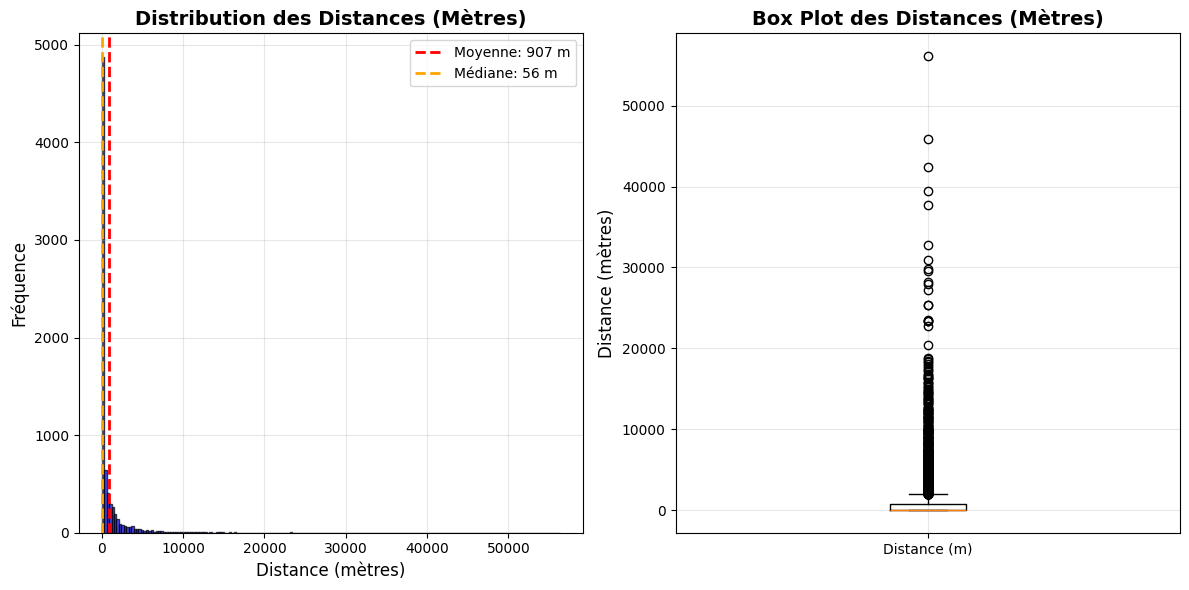


=== STATISTIQUES DISTANCE (MÈTRES) ===
  - Moyenne: 907 mètres
  - Médiane: 56 mètres
  - Min: 0 mètres
  - Max: 56148 mètres
  - Écart-type: 2505 mètres


In [20]:
sample_size = 0.001
sample_data = data.select("Distance(m)").sample(sample_size, seed=42).toPandas()

print(f"Taille de l'échantillon pour visualisation: {len(sample_data)} lignes")

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
meters_bins = np.arange(0, sample_data['Distance(m)'].max() + 500, 300)
plt.hist(sample_data['Distance(m)'], bins=meters_bins, alpha=0.7, color='blue', edgecolor='black')
plt.title('Distribution des Distances (Mètres)', fontsize=14, fontweight='bold')
plt.xlabel('Distance (mètres)', fontsize=12)
plt.ylabel('Fréquence', fontsize=12)
plt.grid(True, alpha=0.3)

meters_mean = sample_data['Distance(m)'].mean()
meters_median = sample_data['Distance(m)'].median()
plt.axvline(meters_mean, color='red', linestyle='--', linewidth=2, label=f'Moyenne: {meters_mean:.0f} m')
plt.axvline(meters_median, color='orange', linestyle='--', linewidth=2, label=f'Médiane: {meters_median:.0f} m')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(sample_data['Distance(m)'], labels=['Distance (m)'])
plt.title('Box Plot des Distances (Mètres)', fontsize=14, fontweight='bold')
plt.ylabel('Distance (mètres)', fontsize=12)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n=== STATISTIQUES DISTANCE (MÈTRES) ===")
print(f"  - Moyenne: {meters_mean:.0f} mètres")
print(f"  - Médiane: {meters_median:.0f} mètres")
print(f"  - Min: {sample_data['Distance(m)'].min():.0f} mètres")
print(f"  - Max: {sample_data['Distance(m)'].max():.0f} mètres")
print(f"  - Écart-type: {sample_data['Distance(m)'].std():.0f} mètres")

In [21]:
# 10 miles = 10 * 1609.344 = 16093.44 mètres
MAX_DISTANCE_METERS = 16093.44

print("Nombre de lignes avant filtrage:", data.count())
print(f"Nombre de lignes avec distance > {MAX_DISTANCE_METERS} m:", data.filter(col("Distance(m)") > MAX_DISTANCE_METERS).count())
print(f"Nombre de lignes avec distance = 0 m:", data.filter(col("Distance(m)") == 0).count())

data = data.filter((col("Distance(m)") <= MAX_DISTANCE_METERS) & (col("Distance(m)") > 0))

print("Nombre de lignes après filtrage:", data.count())
print("\nStatistiques après filtrage:")

Nombre de lignes avant filtrage: 7728394
Nombre de lignes avec distance > 16093.44 m: 35518
Nombre de lignes avec distance > 16093.44 m: 35518
Nombre de lignes avec distance = 0 m: 3302161
Nombre de lignes avec distance = 0 m: 3302161
Nombre de lignes après filtrage: 4390715

Statistiques après filtrage:
Nombre de lignes après filtrage: 4390715

Statistiques après filtrage:


In [22]:
distance_stats = data.select(
    min(col("Distance(m)")).alias("min_distance"),
    max(col("Distance(m)")).alias("max_distance"),
    mean(col("Distance(m)")).alias("mean_distance"),
    stddev(col("Distance(m)")).alias("std_distance"),
    count(col("Distance(m)")).alias("count_distance")
)

print("Statistiques de la colonne Distance(m):")
distance_stats.show()

print("\nNombre de valeurs nulles dans Distance(m):")
print(data.filter(col("Distance(m)").isNull()).count())

print("Nombre de valeurs négatives dans Distance(m):")
print(data.filter(col("Distance(m)") < 0).count())

print("Nombre de valeurs égales à 0 dans Distance(m):")
print(data.filter(col("Distance(m)") == 0).count())

Statistiques de la colonne Distance(m):
+------------+------------+------------------+------------------+--------------+
|min_distance|max_distance|     mean_distance|      std_distance|count_distance|
+------------+------------+------------------+------------------+--------------+
|    1.609344|    16093.44|1363.3276824082923|2147.7813258562924|       4390715|
+------------+------------+------------------+------------------+--------------+


Nombre de valeurs nulles dans Distance(m):
+------------+------------+------------------+------------------+--------------+
|min_distance|max_distance|     mean_distance|      std_distance|count_distance|
+------------+------------+------------------+------------------+--------------+
|    1.609344|    16093.44|1363.3276824082923|2147.7813258562924|       4390715|
+------------+------------+------------------+------------------+--------------+


Nombre de valeurs nulles dans Distance(m):
0
Nombre de valeurs négatives dans Distance(m):
0
Nombre de 

In [23]:
data_log = data.withColumn(
    "Distance_Log", 
    when(col("Distance(m)") > 0, log(col("Distance(m)") + 1)).otherwise(0)
)

print("Statistiques après transformation logarithmique (sur Distance en mètres):")
data_log.select(
    min(col("Distance_Log")).alias("min"),
    max(col("Distance_Log")).alias("max"),
    mean(col("Distance_Log")).alias("mean"),
    stddev(col("Distance_Log")).alias("std")
).show()

print("\nComparaison - Distance en mètres vs log transformée:")
data_log.select(
    mean(col("Distance(m)")).alias("mean_meters"),
    stddev(col("Distance(m)")).alias("std_meters"),
    mean(col("Distance_Log")).alias("mean_log"),
    stddev(col("Distance_Log")).alias("std_log")
).show()

Statistiques après transformation logarithmique (sur Distance en mètres):
+------------------+---------------+-----------------+----------------+
|               min|            max|             mean|             std|
+------------------+---------------+-----------------+----------------+
|0.9590988487469918|9.6862291497135|6.092364700109243|1.72175860286346|
+------------------+---------------+-----------------+----------------+


Comparaison - Distance en mètres vs log transformée:
+------------------+---------------+-----------------+----------------+
|               min|            max|             mean|             std|
+------------------+---------------+-----------------+----------------+
|0.9590988487469918|9.6862291497135|6.092364700109243|1.72175860286346|
+------------------+---------------+-----------------+----------------+


Comparaison - Distance en mètres vs log transformée:
+------------------+------------------+-----------------+----------------+
|       mean_meters| 

## Normalisation de la colonne Distance(m)

In [24]:
data = data.withColumn(
    "Distance_Normalized", 
    when(col("Distance(m)") > 0, log(col("Distance(m)") + 1)).otherwise(0)
)

feature_cols_final = ["Start_Lat", "Start_Lng", "Distance(m)", "Amenity", "Bump", "Crossing", "Give_Way",
                      "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", 
                      "Traffic_Signal", "Turning_Loop","Sunrise_Sunset_index", "Civil_Twilight_index", 
                      "Nautical_Twilight_index", "Astronomical_Twilight_index", "duration", "Start_Year", 
                      "Start_Month", "Start_Day", "Start_Hour", "Start_Minute", "Start_Second", "End_Year", 
                      "End_Month", "End_Day", "End_Hour", "End_Minute", "End_Second", "Timezone_index", 
                      "State_index", "is_weekend", "is_night"]

print("Features finales utilisant Distance(m) en mètres:")
print(f"Nombre de features: {len(feature_cols_final)}")
data.select("Distance(m)").show(10)

Features finales utilisant Distance(m) en mètres:
Nombre de features: 37
+-----------+
|Distance(m)|
+-----------+
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
|   16.09344|
+-----------+
only showing top 10 rows


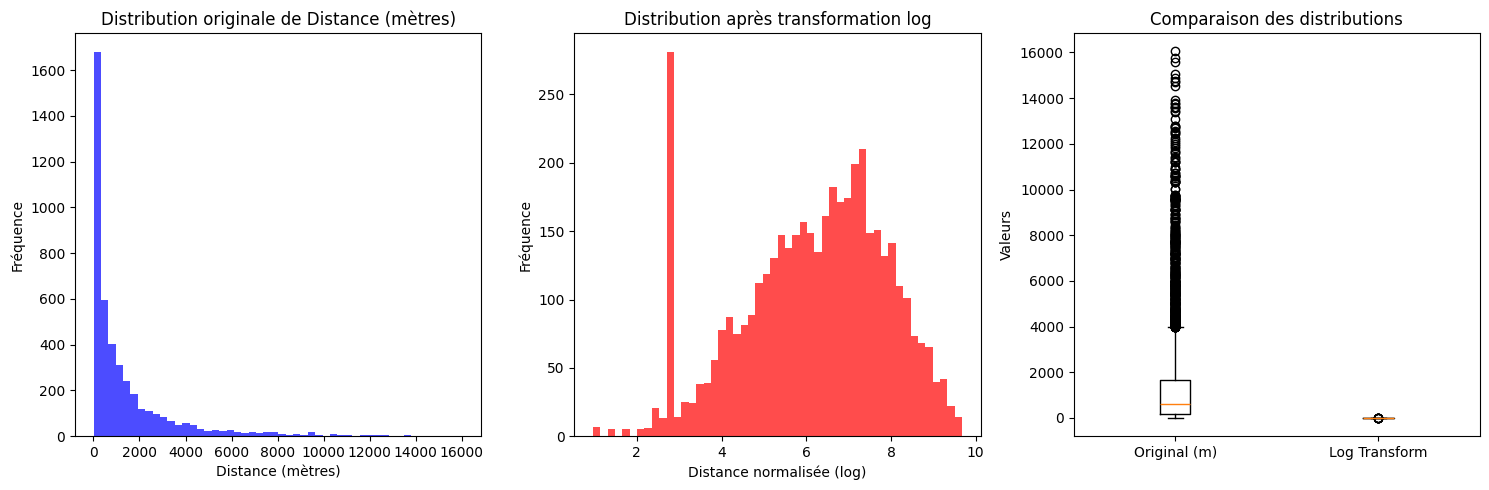


Statistiques de l'échantillon:
Distance originale (m) - Moyenne: 1438, Médiane: 590
Distance normalisée - Moyenne: 6.156, Médiane: 6.382
Coefficient d'asymétrie (skewness) - Original: 2.820, Normalisé: -0.402


In [25]:
sample_data = data.select("Distance(m)", "Distance_Normalized").sample(0.001, seed=42).toPandas()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(sample_data["Distance(m)"], bins=50, alpha=0.7, color='blue')
plt.title('Distribution originale de Distance (mètres)')
plt.xlabel('Distance (mètres)')
plt.ylabel('Fréquence')

plt.subplot(1, 3, 2)
plt.hist(sample_data["Distance_Normalized"], bins=50, alpha=0.7, color='red')
plt.title('Distribution après transformation log')
plt.xlabel('Distance normalisée (log)')
plt.ylabel('Fréquence')

plt.subplot(1, 3, 3)
data_to_plot = [sample_data["Distance(m)"], sample_data["Distance_Normalized"]]
plt.boxplot(data_to_plot, tick_labels=['Original (m)', 'Log Transform'])
plt.title('Comparaison des distributions')
plt.ylabel('Valeurs')

plt.tight_layout()
plt.show()

print(f"\nStatistiques de l'échantillon:")
print(f"Distance originale (m) - Moyenne: {sample_data['Distance(m)'].mean():.0f}, Médiane: {sample_data['Distance(m)'].median():.0f}")
print(f"Distance normalisée - Moyenne: {sample_data['Distance_Normalized'].mean():.3f}, Médiane: {sample_data['Distance_Normalized'].median():.3f}")
print(f"Coefficient d'asymétrie (skewness) - Original: {sample_data['Distance(m)'].skew():.3f}, Normalisé: {sample_data['Distance_Normalized'].skew():.3f}")

# Modèles de Régression pour Prédire la Distance

Nous allons tester plusieurs algorithmes de régression pour prédire la distance en mètres :

1. **Linear Regression**
2. **Gradient Boosted Trees**
3. **Random Forest Regression** 
4. **Decision Tree Regression**

Chaque modèle sera évalué avec les métriques :
- **RMSE** (Root Mean Square Error)
- **MAE** (Mean Absolute Error) 
- **R²** (Coefficient de détermination)

In [26]:
evaluator_rmse = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="mae")
evaluator_r2 = RegressionEvaluator(labelCol="label", predictionCol="prediction", metricName="r2")

results = {}

feature_cols = ["Start_Lat", "Start_Lng", "Amenity", "Bump", "Crossing", "Give_Way",
                "Junction", "No_Exit", "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", 
                "Traffic_Signal", "Turning_Loop","Sunrise_Sunset_index", "Civil_Twilight_index", 
                "Nautical_Twilight_index", "Astronomical_Twilight_index", "duration", "Start_Year", 
                "Start_Month", "Start_Day", "Start_Hour", "Start_Minute", "Start_Second", "End_Year", 
                "End_Month", "End_Day", "End_Hour", "End_Minute", "End_Second", "Timezone_index", 
                "State_index", "is_weekend", "is_night"]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_ml = assembler.transform(data)

data_final = data_ml.select("features", col("Distance(m)").alias("label"))

train_df, test_df = data_final.randomSplit([0.8, 0.2], seed=42)

print(f"Dataset préparé !")
print(f"Training set: {train_df.count()} lignes")
print(f"Test set: {test_df.count()} lignes")
print(f"Features: {len(feature_cols)}")

print("\nAperçu des données:")
train_df.show(5)

Dataset préparé !
Training set: 3513201 lignes
Training set: 3513201 lignes
Test set: 877514 lignes
Features: 36

Aperçu des données:
Test set: 877514 lignes
Features: 36

Aperçu des données:
+--------------------+--------+
|            features|   label|
+--------------------+--------+
|(36,[0,1,2,3,4,12...|16.09344|
|(36,[0,1,2,3,12,1...|16.09344|
|(36,[0,1,2,4,5,10...|16.09344|
|(36,[0,1,2,4,5,10...|16.09344|
|(36,[0,1,2,4,5,10...|16.09344|
+--------------------+--------+
only showing top 5 rows
+--------------------+--------+
|            features|   label|
+--------------------+--------+
|(36,[0,1,2,3,4,12...|16.09344|
|(36,[0,1,2,3,12,1...|16.09344|
|(36,[0,1,2,4,5,10...|16.09344|
|(36,[0,1,2,4,5,10...|16.09344|
|(36,[0,1,2,4,5,10...|16.09344|
+--------------------+--------+
only showing top 5 rows


In [27]:
assembler_log = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_ml_log = assembler_log.transform(data_log)

data_final_log = data_ml_log.select("features", col("Distance_Log").alias("label"))

train_df_log, test_df_log = data_final_log.randomSplit([0.8, 0.2], seed=42)

print(f"  Training set: {train_df_log.count()} lignes")
print(f"  Test set: {test_df_log.count()} lignes")

  Training set: 3513201 lignes
  Test set: 877514 lignes
  Test set: 877514 lignes


## Linear Regression

In [28]:
lr = LinearRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,
    regParam=0.01,       
    elasticNetParam=0.1  
)
start_time = time.time()
lr_model = lr.fit(train_df_log)
lr_predictions = lr_model.transform(test_df_log)
training_time = time.time() - start_time

In [29]:
lr_rmse = evaluator_rmse.evaluate(lr_predictions)
lr_mae = evaluator_mae.evaluate(lr_predictions)
lr_r2 = evaluator_r2.evaluate(lr_predictions)

results['Linear Regression'] = {
    'RMSE': lr_rmse,
    'MAE': lr_mae,
    'R²': lr_r2,
    'Training Time': training_time
}

print(f"RÉSULTATS LINEAR REGRESSION:")
print(f"- RMSE: {lr_rmse:.4f}")
print(f"- MAE: {lr_mae:.4f}")
print(f"- R²: {lr_r2:.4f}")
print(f"- Temps d'entraînement: {training_time:.2f} secondes")

print(f"\nÉchantillon de prédictions:")
lr_predictions.select("label", "prediction").show(10)


RÉSULTATS LINEAR REGRESSION:
- RMSE: 1.5625
- MAE: 1.2817
- R²: 0.1769
- Temps d'entraînement: 18.93 secondes

Échantillon de prédictions:
+-----------------+------------------+
|            label|        prediction|
+-----------------+------------------+
|2.838694764174445| 2.689494587250408|
|2.838694764174445| 2.573154146665445|
|2.838694764174445| 2.951201902300795|
|2.838694764174445|3.3502125085904026|
|2.838694764174445| 2.851558971507643|
|2.838694764174445|2.7607611740665448|
|2.838694764174445|2.4963236354083733|
|2.838694764174445| 2.778177559646167|
|2.838694764174445|3.5520437003391407|
|2.838694764174445|4.1740534022430325|
+-----------------+------------------+
only showing top 10 rows
+-----------------+------------------+
|            label|        prediction|
+-----------------+------------------+
|2.838694764174445| 2.689494587250408|
|2.838694764174445| 2.573154146665445|
|2.838694764174445| 2.951201902300795|
|2.838694764174445|3.3502125085904026|
|2.83869476417444

## Gradient Boosted Tree Regressor

In [30]:
gbt = GBTRegressor(
    featuresCol="features",
    labelCol="label",
    maxIter=100,        
    maxDepth=10,         
    maxBins=64,         
    seed=42
)
start_time = time.time()
gbt_model = gbt.fit(train_df_log)
gbt_predictions = gbt_model.transform(test_df_log)
training_time = time.time() - start_time


In [31]:
gbt_rmse = evaluator_rmse.evaluate(gbt_predictions)
gbt_mae = evaluator_mae.evaluate(gbt_predictions)
gbt_r2 = evaluator_r2.evaluate(gbt_predictions)

results['GBT'] = {
    'RMSE': gbt_rmse,
    'MAE': gbt_mae,
    'R²': gbt_r2,
    'Training Time': training_time
}

print(f"RÉSULTATS GBT:")
print(f"- RMSE: {gbt_rmse:.2f} mètres")
print(f"- MAE: {gbt_mae:.2f} mètres")
print(f"- R²: {gbt_r2:.4f}")
print(f"- Temps d'entraînement: {training_time:.2f} secondes")

print(f"\nÉchantillon de prédictions:")
gbt_predictions.select("label", "prediction").show(10)

RÉSULTATS GBT:
- RMSE: 1.13 mètres
- MAE: 0.84 mètres
- R²: 0.5709
- Temps d'entraînement: 704.15 secondes

Échantillon de prédictions:
+-----------------+------------------+
|            label|        prediction|
+-----------------+------------------+
|2.838694764174445| 2.753823947641745|
|2.838694764174445| 4.230863423551423|
|2.838694764174445| 2.876130339124208|
|2.838694764174445| 3.433834839121897|
|2.838694764174445|2.8470355321113914|
|2.838694764174445|2.9761003472435794|
|2.838694764174445|3.1056969959856233|
|2.838694764174445| 3.072044570381271|
|2.838694764174445|2.8403195225450357|
|2.838694764174445|2.9789815858617863|
+-----------------+------------------+
only showing top 10 rows
+-----------------+------------------+
|            label|        prediction|
+-----------------+------------------+
|2.838694764174445| 2.753823947641745|
|2.838694764174445| 4.230863423551423|
|2.838694764174445| 2.876130339124208|
|2.838694764174445| 3.433834839121897|
|2.838694764174445|2

## Random Forest

In [32]:
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="label",  
    numTrees=100,  
    maxDepth=15, 
    maxBins=64, 
    seed=42
)

start_time = time.time()
rf_model = rf.fit(train_df_log)
rf_predictions = rf_model.transform(test_df_log)
training_time = time.time() - start_time


In [33]:
rf_rmse = evaluator_rmse.evaluate(rf_predictions)
rf_mae = evaluator_mae.evaluate(rf_predictions)
rf_r2 = evaluator_r2.evaluate(rf_predictions)



results['Random Forest'] = {
    'RMSE': rf_rmse,
    'MAE': rf_mae,
    'R²': rf_r2,
    'Training Time': training_time
}

print(f"RÉSULTATS RANDOM FOREST:")
print(f"- RMSE: {rf_rmse:.2f} mètres")
print(f"- MAE: {rf_mae:.2f} mètres")
print(f"- R²: {rf_r2:.4f}")
print(f"- Temps d'entraînement: {training_time:.2f} secondes")
print(f"- Nombre de features: {rf_model.numFeatures}")

print(f"\nÉchantillon de prédictions (mètres):")
rf_predictions.select("label", "prediction").show(10)

RÉSULTATS RANDOM FOREST:
- RMSE: 1.20 mètres
- MAE: 0.91 mètres
- R²: 0.5138
- Temps d'entraînement: 708.55 secondes
- Nombre de features: 36

Échantillon de prédictions (mètres):
+-----------------+------------------+
|            label|        prediction|
+-----------------+------------------+
|2.838694764174445|2.9698196123042413|
|2.838694764174445| 4.104766940336758|
|2.838694764174445| 2.866612090178525|
|2.838694764174445| 3.046129283723662|
|2.838694764174445| 2.903846756015858|
|2.838694764174445|3.0019315984410495|
|2.838694764174445|2.8720205101196483|
|2.838694764174445|3.0023947393312107|
|2.838694764174445|2.8937409881126275|
|2.838694764174445| 2.967913713487046|
+-----------------+------------------+
only showing top 10 rows
+-----------------+------------------+
|            label|        prediction|
+-----------------+------------------+
|2.838694764174445|2.9698196123042413|
|2.838694764174445| 4.104766940336758|
|2.838694764174445| 2.866612090178525|
|2.838694764174

## Decision Tree Regressor

In [34]:
dt = DecisionTreeRegressor(
    featuresCol="features",
    labelCol="label",
    maxDepth=15,         
    minInstancesPerNode=1,
    maxBins=64,      
    seed=42
)

start_time = time.time()
dt_model = dt.fit(train_df_log)
dt_predictions = dt_model.transform(test_df_log)
training_time = time.time() - start_time

In [35]:
dt_rmse = evaluator_rmse.evaluate(dt_predictions)
dt_mae = evaluator_mae.evaluate(dt_predictions)
dt_r2 = evaluator_r2.evaluate(dt_predictions)

results['Decision Tree'] = {
    'RMSE': dt_rmse,
    'MAE': dt_mae,
    'R²': dt_r2,
    'Training Time': training_time
}

print(f"RÉSULTATS DECISION TREE:")
print(f"- RMSE: {dt_rmse:.2f} mètres")
print(f"- MAE: {dt_mae:.2f} mètres")
print(f"- R²: {dt_r2:.4f}")
print(f"- Temps d'entraînement: {training_time:.2f} secondes")

print(f"\nÉchantillon de prédictions (mètres):")
dt_predictions.select("label", "prediction").show(10)

RÉSULTATS DECISION TREE:
- RMSE: 1.23 mètres
- MAE: 0.92 mètres
- R²: 0.4882
- Temps d'entraînement: 35.23 secondes

Échantillon de prédictions (mètres):
+-----------------+------------------+
|            label|        prediction|
+-----------------+------------------+
|2.838694764174445| 2.943998356351766|
|2.838694764174445|3.2477787578876853|
|2.838694764174445|2.8419991080395275|
|2.838694764174445|2.8386947641744475|
|2.838694764174445|  2.85678744522839|
|2.838694764174445|3.3554705666387945|
|2.838694764174445| 2.838694764174446|
|2.838694764174445| 2.838694764174445|
|2.838694764174445| 2.838694764174448|
|2.838694764174445| 3.002773053578157|
+-----------------+------------------+
only showing top 10 rows
+-----------------+------------------+
|            label|        prediction|
+-----------------+------------------+
|2.838694764174445| 2.943998356351766|
|2.838694764174445|3.2477787578876853|
|2.838694764174445|2.8419991080395275|
|2.838694764174445|2.8386947641744475|
|2

## Comparaison et Analyse des Résultats

In [36]:
comparison_df = pd.DataFrame(results).T
comparison_df = comparison_df.round(4)

comparison_df_sorted = comparison_df.sort_values('R²', ascending=False)

print("Classement par performance (R² décroissant):")
print(comparison_df_sorted.to_string())

best_model = comparison_df_sorted.index[0]
best_r2 = comparison_df_sorted.loc[best_model, 'R²']
best_rmse = comparison_df_sorted.loc[best_model, 'RMSE']

print(f"\nMEILLEUR MODÈLE: {best_model}")
print(f"- R² = {best_r2:.4f}")
print(f"- RMSE = {best_rmse:.2f} mètres")

Classement par performance (R² décroissant):
                     RMSE     MAE      R²  Training Time
GBT                1.1282  0.8416  0.5709       704.1507
Random Forest      1.2009  0.9076  0.5138       708.5547
Decision Tree      1.2321  0.9177  0.4882        35.2293
Linear Regression  1.5625  1.2817  0.1769        18.9331

MEILLEUR MODÈLE: GBT
- R² = 0.5709
- RMSE = 1.13 mètres


## Analyse des Features Importantes

Importance des features (Random Forest):

TOP 10 des features les plus importantes:
       Feature  Importance
      duration    0.264716
      End_Year    0.144301
    Start_Year    0.115827
   State_index    0.102045
Traffic_Signal    0.081598
    End_Second    0.061189
      Crossing    0.050222
     Start_Lat    0.025237
  Start_Second    0.022746
     End_Month    0.021957

TOP 10 des features les plus importantes:
       Feature  Importance
      duration    0.264716
      End_Year    0.144301
    Start_Year    0.115827
   State_index    0.102045
Traffic_Signal    0.081598
    End_Second    0.061189
      Crossing    0.050222
     Start_Lat    0.025237
  Start_Second    0.022746
     End_Month    0.021957


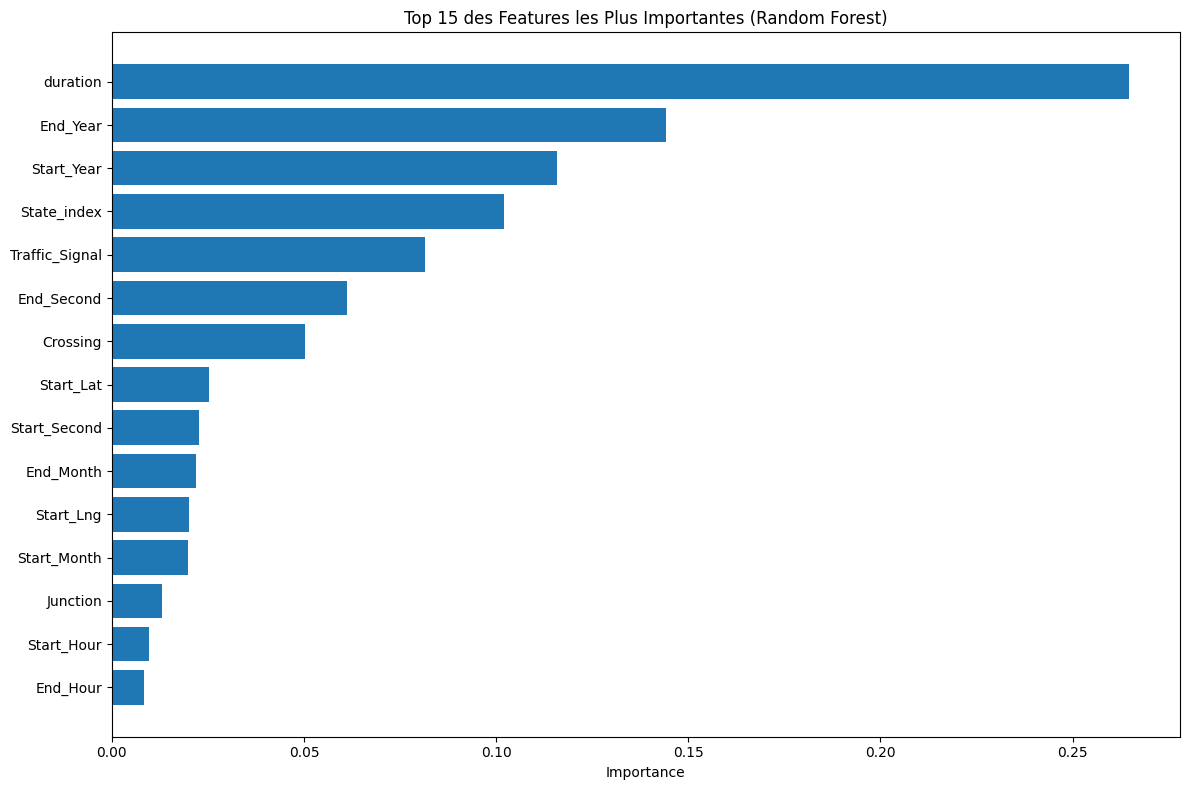


INSIGHTS:
• Les 3 features les plus importantes: duration, End_Year, Start_Year
• Les 10 meilleures features expliquent 89.0% de la variance


In [37]:

print("Importance des features (Random Forest):")
feature_importances = rf_model.featureImportances.toArray()

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)
    
print("\nTOP 10 des features les plus importantes:")
print(importance_df.head(10).to_string(index=False))

plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['Importance'])
plt.yticks(range(len(top_features)), top_features['Feature'])
plt.xlabel('Importance')
plt.title('Top 15 des Features les Plus Importantes (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("\nINSIGHTS:")
top_3_features = importance_df.head(3)['Feature'].tolist()
print(f"• Les 3 features les plus importantes: {', '.join(top_3_features)}")
    
total_importance_top10 = importance_df.head(10)['Importance'].sum()
print(f"• Les 10 meilleures features expliquent {total_importance_top10:.1%} de la variance")

## Fine Tuning de GBT

In [38]:
configs = [
    {"maxIter": 120, "maxDepth": 10, "stepSize": 0.08, "maxBins": 64},
    {"maxIter": 100, "maxDepth": 12, "stepSize": 0.08, "maxBins": 64},
    {"maxIter": 100, "maxDepth": 10, "stepSize": 0.08, "maxBins": 128}, 
    {"maxIter": 120, "maxDepth": 12, "stepSize": 0.06, "maxBins": 128},
    {"maxIter": 100, "maxDepth": 10, "stepSize": 0.12, "maxBins": 64},
    {"maxIter": 110, "maxDepth": 11, "stepSize": 0.09, "maxBins": 96} 
]

best_config = None
best_r2 = -1

for i, config in enumerate(configs):
    print(f"\n=== Configuration {i+1} ===")
    
    gbt_tuned = GBTRegressor(
        featuresCol="features",
        labelCol="label",
        maxIter=config["maxIter"],
        maxDepth=config["maxDepth"],
        stepSize=config["stepSize"],
        maxBins=config["maxBins"],
        seed=42
    )
    
    start_time = time.time()
    model = gbt_tuned.fit(train_df_log)
    predictions = model.transform(test_df_log)
    training_time = time.time() - start_time
    

    rmse = evaluator_rmse.evaluate(predictions)
    mae = evaluator_mae.evaluate(predictions)
    r2 = evaluator_r2.evaluate(predictions)
    
    print(f"R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    print(f"Temps: {training_time:.2f}s")
    
    if r2 > best_r2:
        best_r2 = r2
        best_config = config
        best_predictions = predictions


=== Configuration 1 ===
R²: 0.5695, RMSE: 1.1300, MAE: 0.8431
Temps: 1097.03s

=== Configuration 2 ===
R²: 0.5695, RMSE: 1.1300, MAE: 0.8431
Temps: 1097.03s

=== Configuration 2 ===
R²: 0.5820, RMSE: 1.1135, MAE: 0.8268
Temps: 2848.51s

=== Configuration 3 ===
R²: 0.5820, RMSE: 1.1135, MAE: 0.8268
Temps: 2848.51s

=== Configuration 3 ===
R²: 0.5716, RMSE: 1.1272, MAE: 0.8409
Temps: 768.57s

=== Configuration 4 ===
R²: 0.5716, RMSE: 1.1272, MAE: 0.8409
Temps: 768.57s

=== Configuration 4 ===
R²: 0.5880, RMSE: 1.1054, MAE: 0.8201
Temps: 4076.69s

=== Configuration 5 ===
R²: 0.5880, RMSE: 1.1054, MAE: 0.8201
Temps: 4076.69s

=== Configuration 5 ===
R²: 0.5738, RMSE: 1.1243, MAE: 0.8384
Temps: 25730.70s

=== Configuration 6 ===
R²: 0.5738, RMSE: 1.1243, MAE: 0.8384
Temps: 25730.70s

=== Configuration 6 ===
R²: 0.5837, RMSE: 1.1112, MAE: 0.8268
Temps: 1836.09s
R²: 0.5837, RMSE: 1.1112, MAE: 0.8268
Temps: 1836.09s


In [39]:
print(f"\nMeilleure configuration: {best_config}")
print(f"Meilleur R²: {best_r2:.4f}")


Meilleure configuration: {'maxIter': 120, 'maxDepth': 12, 'stepSize': 0.06, 'maxBins': 128}
Meilleur R²: 0.5880
